# Faster and Smaller Whisper utilizing Quantization and Torch Compilation

This colab shows the example and benchmarking of the whisper models leveraging the torch.compile and quantization using HQQ. More details can be found at https://mobiusml.github.io/whisper-static-cache-blog/

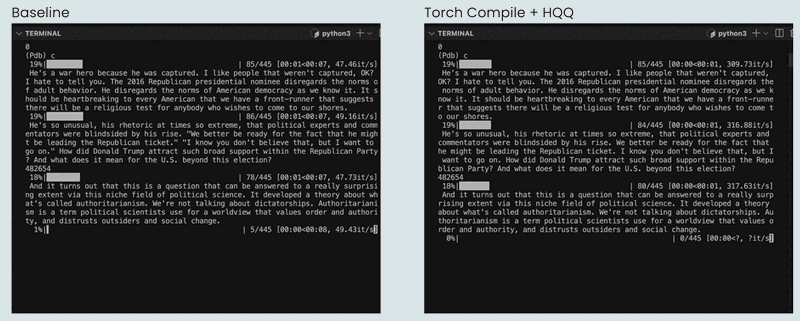

To achieve the speedup reported in the blog, you will need a modern GPU. In Colab, this is restricted to A100s and L40s (unfortunately not available in the free tiers 😞).

To achieve the speedup, you need a static cache implementation. At the time of writing, there is a PR (https://github.com/huggingface/transformers/pull/30760#discussion_r1606974803) but it has not been incorporated into Hugging Face Transformers yet.

Let us walk through the implementation steps:


## 1. Setup the Inference Environment

In [ ]:
# !pip install -q --pre torch -f https://download.pytorch.org/whl/nightly/cu121/torch_nightly.html
!pip install -q torch
!pip install -q git+https://github.com/mobiusml/hqq.git
!pip install -q git+https://github.com/mesolitica/whisper-static-cache.git
!pip install -q jiwer
!pip install -q -U datasets
!pip install -q soundfile
!pip install -q librosa

  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## 2. Import the necessary libraries:

In [ ]:
import torch
from transformers import WhisperForConditionalGeneration, AutoProcessor, pipeline
from transformers.cache_utils import WhisperStaticCache
from datasets import Audio, load_dataset
from tqdm.auto import tqdm
import requests
import json
import os


## 3. Define configuration:

in this step we add whisper model type and quantization/torch compilation flag and other variable intitializations.

In [ ]:
sr = 16000
audio = Audio(sampling_rate=sr)
model_id = "openai/whisper-large-v2" #@param [ "openai/whisper-large-v2", "openai/whisper-large", "openai/whisper-medium", "https://huggingface.co/openai/whisper-base"]
compute_dtype = torch.bfloat16
device = "cuda:0"
quantize = "False" #@param ["True", "False"]
compile = "False" #@param ["True", "False"]




## 4. Helper Functions:

In [ ]:
#@title decode_one_tokens(): This function will be called per token generation in the decoding step. This will generate a single token at a time.
def decode_one_tokens(
    model,
    proj_out,
    cur_token,
    past_key_values,
    position_ids,
    cache_position,
    out_encoder,
):
    out_decoder = model(
        cur_token,
        encoder_hidden_states=out_encoder,
        past_key_values = past_key_values,
        position_ids=position_ids,
        use_cache = True,
        return_dict = False,
        cache_position = cache_position
    )

    new_token = torch.argmax(proj_out(out_decoder[0][:,-1:]), dim=-1)

    return new_token

In [ ]:
#@title extract_transcription_sample(): Run Inference for an audio sample
def extract_transcription_sample(inputs, labels_init, max_length):

    with torch.backends.cuda.sdp_kernel(enable_flash=True, enable_mem_efficient=False, enable_math=True):
        out_encoder = model.model.encoder(inputs['input_features'])

    out_decoder = model.model.decoder(
        labels_init,
        encoder_hidden_states=out_encoder[0],
        past_key_values=None,
        use_cache=True
    )

    past_key_values = out_decoder.past_key_values
    proj = model.proj_out(out_decoder.last_hidden_state[:, -1:]).argmax(-1)
    out_encoder = out_encoder[0].clone()

    cache.reset(existing_cache=past_key_values)
    seq_length = past_key_values[0][0].shape[2]
    cache_position = torch.tensor([seq_length], device=device)
    position_ids = torch.arange(seq_length, seq_length + proj.shape[1], device=device)
    labels = torch.zeros((1, max_length))

    # Inner loop for target positions with tqdm
    inner_tqdm = tqdm(range(model.config.max_target_positions - len(initial_strings)), desc="Decoding", position=1, leave=False)
    for i in inner_tqdm:
        if i > max_length-4:
            tqdm._instances.clear()
            inner_tqdm.close()
            break

        proj = decode_one_tokens(
            model.model.decoder,
            model.proj_out,
            proj.clone(),
            cache,
            position_ids,
            cache_position,
            out_encoder
        )
        labels[:, i] = proj

        position_ids += 1
        cache_position += 1
        if proj == model.config.eos_token_id:
            tqdm._instances.clear()
            inner_tqdm.close()
            break

    prediction = processor.tokenizer.decode(labels[0][:i])

    inner_tqdm.close()
    return prediction


In [ ]:
#@title Functions related to open_asr_eval dataset for dataset loading and processing
def load_data(dataset_path, dataset, split, streaming):
    dataset = load_dataset(
        dataset_path,
        dataset,
        split=split,
        streaming=streaming,
        token=False,
    )
    return dataset

def get_text(sample):
    if "text" in sample:
        return sample["text"]
    elif "sentence" in sample:
        return sample["sentence"]
    elif "normalized_text" in sample:
        return sample["normalized_text"]
    elif "transcript" in sample:
        return sample["transcript"]
    elif "transcription" in sample:
        return sample["transcription"]
    else:
        raise ValueError(
            f"Expected transcript column of either 'text', 'sentence', 'normalized_text' or 'transcript'. Got sample of "
            ".join{sample.keys()}. Ensure a text column name is present in the dataset."
        )

def batch_text(batch):
    batch["original_text"] = get_text(batch)
    return batch

def dataset_iterator(dataset):
    for i, item in enumerate(dataset):
        dur = len(item['audio']['array'])/item['audio']['sampling_rate']
        #limit generation to 30 sec
        if dur > 30.0:
            item['audio']['array'] = item['audio']['array'][:480000]
        yield {**item["audio"], "reference": item["text"]}

def is_target_text_in_range(ref):
    if ref.strip() == "ignore time segment in scoring":
        return False
    else:
        return ref.strip() != ""

def prepare_data(dataset):
    # Re-sample to 16kHz and normalise transcriptions
    dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))
    dataset = dataset.map(batch_text)
    dataset = dataset.filter(is_target_text_in_range, input_columns=["original_text"])
    return dataset

## 5. Load the whisper model and quantize and/or compile:
Now we load the whisper model and torch compile the decoder. If quantize is enabled, model will be loaded with quantized bits. We also preallocate WhisperStaticCache() for fast inference in decoding time.

In [ ]:
model = WhisperForConditionalGeneration.from_pretrained(model_id, torch_dtype = compute_dtype)
processor = AutoProcessor.from_pretrained(model_id)

if quantize:

    from hqq.models.hf.base import AutoHQQHFModel
    from hqq.core.quantize import *

    nbits = 4  #@param
    group_size = 64 #@param

    quant_config = BaseQuantizeConfig(nbits=nbits, group_size=group_size, quant_scale=False, quant_zero=False, axis=1)
    HQQLinear.set_backend(HQQBackend.PYTORCH)

    model.model.encoder = model.model.encoder.to(device)
    AutoHQQHFModel.quantize_model(model.model.decoder, quant_config=quant_config, compute_dtype=compute_dtype, device=device)

    from hqq.utils.patching import prepare_for_inference
    prepare_for_inference(model.model.decoder, backend="torchao_int4")
else:
    _ = model.cuda()


#Compile
if(compile):
    decode_one_tokens = torch.compile(decode_one_tokens, mode="reduce-overhead", fullgraph=True)


encoder_cache_shape = (
                        1,
                        model.config.encoder_attention_heads,
                        model.config.max_source_positions,
                        model.config.d_model // model.config.decoder_attention_heads
                    )
decoder_cache_shape = (
                        1,
                        model.config.decoder_attention_heads,
                        model.config.max_target_positions - 2,
                        model.config.d_model // model.config.decoder_attention_heads
                    )

e_key_cache = torch.zeros(encoder_cache_shape, dtype=compute_dtype, device=device)
e_value_cache = torch.zeros(encoder_cache_shape, dtype=compute_dtype, device=device)
key_cache =  torch.zeros(decoder_cache_shape, dtype=compute_dtype, device=device)
value_cache =  torch.zeros(decoder_cache_shape, dtype=compute_dtype, device=device)

cache_size = []
for i in range(model.config.num_hidden_layers):
    cache_size.append(( key_cache, value_cache, e_key_cache, e_value_cache))

#preallocate cache
with torch.no_grad():
    cache = WhisperStaticCache(model.config, compute_dtype, device, cache_size, 1)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 320/320 [00:04<00:00, 66.28it/s]


## 7. Load an example audio and extract features for first 30 sec. This will be then used for warming up.

In [ ]:
r = requests.get('https://huggingface.co/datasets/reach-vb/random-audios/resolve/main/4469669-10.mp3')
y = audio.decode_example(audio.encode_example(r.content))['array']
inputs = processor([y], return_tensors = 'pt', sampling_rate=16_000).to('cuda')
inputs['input_features'] = inputs['input_features'].type(compute_dtype)
print(compute_dtype)

torch.bfloat16


## 8. Encoder and decoder warm-up
Warmup iterations play a crucial role in PyTorch model benchmarking by allowing the model and computational environment to stabilize. During the initial phase, performance is significantly impacted by factors such as JIT compilation, resource allocation, and data loading overhead.

See [here](https://medium.com/@sgurwinderr/pytorch-model-benchmarking-obtaining-accurate-results-by-accounting-for-warmup-5cc40ed59a34#:~:text=Warmup%20iterations%20are%20crucial%20in,loading%20overhead%20significantly%20affect%20performance.) for more details.



In [ ]:
#@title Warming up encoder and decoder
import time

language = 'en'
initial_strings = [
    '<|startoftranscript|>',
    f'<|{language}|>',
    '<|transcribe|>'
]

labels_init = processor.tokenizer(
    ''.join(initial_strings),
    add_special_tokens = False,
    return_tensors = 'pt',
).to('cuda')['input_ids']


max_length = model.config.max_target_positions - len(initial_strings)


#Warming up (running 5 times)
for i in range(5):
    start_time = time.time()
    with torch.no_grad():
        prediction = extract_transcription_sample(inputs, labels_init, max_length)
print(f'Decoding time: {time.time()-start_time}')
print(f'Transcription: {prediction}')


/usr/local/lib/python3.10/dist-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding time: 0.5123805999755859
Transcription:  Now it is time. May I start the presentation on transforming Toshiba to enhance shareholders' value and FY21 second quarter consolidated business results. We are organizing this presentation session on an online basis. From four to five o'clock we will be presenting from our side and followed by a 30-minute question session for the members of the media. The questions


# **Benchmarking Speed**

We further run the speed benchmarks in OpenASR leaderboard dataset.

## 1. Load and prepare data for inference:

In [ ]:
dataset_path = "open-asr-leaderboard/datasets-test-only"
dataset_name = "tedlium" #@param [ "voxpopuli", "tedlium", "earnings22", "ami"]
split = "test"

dataset = load_data(dataset_path, dataset_name, split,True)
dataset = prepare_data(dataset)
language = 'en'
initial_strings = [
    '<|startoftranscript|>',
    f'<|{language}|>',
    '<|transcribe|>'
]

labels_init = processor.tokenizer(
    ''.join(initial_strings),
    add_special_tokens = False,
    return_tensors = 'pt',
).to('cuda')['input_ids']


/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for open-asr-leaderboard/datasets-test-only contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/open-asr-leaderboard/datasets-test-only
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


## 2. Perform inference iterating over the dataset.

When we tested in A100 with compile+HQQ we get around 180 toks/sec

|Configuration|GPU|Toks/Sec|
|-------------|---|--------|
|Compile+HQQ  |A100|~180 |
|Compile+HQQ  |L40|~130 |
|Compile only  |A100|~150 |
|Compile only  |L40|~90 |
|Default  |A100|~30 |
|Default  |L40|~15 |

TQDM should provide a small indication of the toks/sec. However, the true results need to be aggregated and averaged, which can be found at https://mobiusml.github.io/whisper-static-cache-blog/.

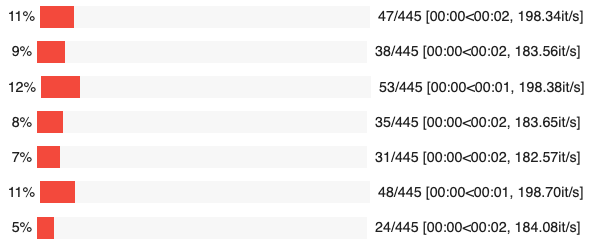

In [ ]:
import time
import torch

start_time = time.time()
predictions = []
# Outer loop for the dataset with tqdm
dataset_iterator_tqdm = tqdm(dataset_iterator(dataset), desc="Dataset", position=0)
with torch.no_grad():
    for data in dataset_iterator_tqdm:
        y = data["array"]
        inputs = processor([y], sampling_rate=sr, return_tensors='pt').to('cuda')  # Add sampling rate here
        inputs['input_features'] = inputs['input_features'].type(compute_dtype)
        prediction = extract_transcription_sample(inputs, labels_init, max_length)
        predictions.append(prediction)
print("Time taken:", time.time() - start_time)
print(f'Example transcription: {predictions[10]}')


Dataset: 0it [00:00, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Decoding:   0%|          | 0/445 [00:00<?, ?it/s]

Time taken: 308.3908004760742
Example transcription:  Of course, this is my raggedy old thesaurus, so I'm thinking this must be an ancient print date, right? But in fact, the print date was the early 1980s.


### **More details of the methodology and extensive benchmark can be found at [our blog here.](https://mobiusml.github.io/whisper-static-cache-blog/)**
